## This notebook illustrates every step of the process of training models for ic labeling.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

First of all, we need the dataset. We can download and it using the following commands.

In [2]:
!curl -O http://alice.adase.org/media/downloads/dataset_Kids_v0.2_TLiCoxo.zip
!unzip dataset_Kids_TLiCoxo.zip

Now, we load the dataset. For this we use the special function, which reads the csv-files from the directory and puts the data in a convenient format.

In [3]:
from alice_ml.preprocessing import load_dataset

path = 'dataset_Kids'

data, raw_annotations = load_dataset(path, preload=False)

Now, we calculate features for each ic in the dataset.

In [4]:
from alice_ml.features import build_feature_df

features = build_feature_df(data)
features

,K,MEV,SAD,SVD,SED,MIF,CORR_BL,CORR_MOVE,AT,MT,AMALB
0,1.072924,7.849818,1.218625,0.312472,0.034570,0.048681,0.019231,0.008782,0.532586,-0.436746,1.011637
1,-0.258669,2.826228,-0.098488,-0.017333,0.198680,0.194712,0.000708,0.000991,0.117395,0.040816,2.849186
2,-0.281039,2.405500,0.048190,-0.005600,0.195810,0.135989,0.000826,0.001222,0.156479,-0.006563,3.377169
3,-0.109386,2.304496,-0.153483,-0.047035,0.102357,0.137081,0.001293,0.000845,-0.015456,0.105652,3.772572
4,-0.184636,2.180311,-0.098674,-0.010143,0.185123,0.238028,0.000109,0.000302,-0.036227,0.126880,3.964019
...,...,...,...,...,...,...,...,...,...,...,...
615,-0.146957,6.988684,0.042727,-0.004911,0.025780,0.121094,0.000665,0.001510,0.065716,0.016142,3.993653
616,-0.239456,3.270491,-0.024471,-0.000694,0.116370,0.088207,0.001756,0.001765,-0.005558,0.079040,4.264880
617,-0.205477,4.605998,0.052680,0.000121,0.037387,0.114119,0.000769,0.000845,0.049253,-0.022909,4.072748
618,-0.177250,3.021220,-0.042368,-0.000086,0.097905,0.117893,0.000812,0.001312,-0.050189,0.038057,4.659919


Targets are calculated as the average of the answers of multiple experts for each ic.

In [5]:
def get_target_distribution(annotations):
    return annotations.groupby('ic_id').mean().apply(lambda x: x.value_counts())

get_target_distribution(raw_annotations)

,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_eyes_h,flag_eyes_v,flag_muscles,flag_heart,flag_line_noise,flag_ch_noise
0.000000,92.0,539.0,522.0,242.0,536.0,564.0,297.0,369.0,599.0,365.0
0.142857,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN
0.166667,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN
0.200000,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN
0.250000,NaN,4.0,1.0,3.0,5.0,3.0,NaN,5.0,NaN,NaN
0.333333,48.0,25.0,42.0,145.0,29.0,16.0,89.0,110.0,16.0,78.0
0.500000,44.0,41.0,39.0,176.0,37.0,26.0,85.0,124.0,5.0,115.0
0.666667,91.0,3.0,1.0,19.0,5.0,4.0,47.0,3.0,NaN,25.0
0.750000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.857143,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


For now we do not want to distinguish between eye movement types, so we unite them under `'flag_eyes'`. We also presume the positive label for `'flag_alpha'` or `'flag_mu'` implies the positive label for `'flag_brain'`. Finally, since we do not have sufficient data for distinguishing line noise, we will not consider this flag.

In [6]:
def propogate_labels(annotations):
    return annotations.assign(flag_brain=annotations[['flag_brain', 'flag_alpha', 'flag_mu']].any(axis=1)) \
                      .drop(columns=['flag_line_noise'])

annotations = propogate_labels(raw_annotations)
get_target_distribution(annotations)

,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_eyes_h,flag_eyes_v,flag_muscles,flag_heart,flag_ch_noise
0.000000,91.0,539.0,522.0,242.0,536.0,564.0,297.0,369.0,365.0
0.142857,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN
0.166667,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN
0.200000,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN
0.250000,NaN,4.0,1.0,3.0,5.0,3.0,NaN,5.0,NaN
0.333333,46.0,25.0,42.0,145.0,29.0,16.0,89.0,110.0,78.0
0.500000,44.0,41.0,39.0,176.0,37.0,26.0,85.0,124.0,115.0
0.666667,77.0,3.0,1.0,19.0,5.0,4.0,47.0,3.0,25.0
0.750000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.857143,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In order to get binary labels we apply threshold to these averages. By default, the each label has weight $\frac{1}{n}$, where $n$ is the number of labels given to the ic by this expert. We set the threshold to $0.33$ For flags `alpha` and `mu` we choose a simpler approach: each label has weight $1$. The threshold in this case is equal to $0.5$.

In [8]:
from alice_ml.preprocessing import build_target_df
targets = build_target_df(annotations, weights='uniform', strategy='mean', threshold=0.33)

targets[['flag_alpha', 'flag_mu', 'flag_heart']] = build_target_df(annotations, ['flag_alpha', 'flag_mu', 'flag_heart'], strategy='majority')

print(targets.sum())
targets = targets.loc[:, (targets.mean(axis=0) > 0.05) & (targets.all(axis=0) < 0.95)]
targets.head()

flag_brain       444
flag_alpha        52
flag_mu           55
flag_eyes         57
flag_eyes_h       11
flag_eyes_v       11
flag_muscles     142
flag_heart       133
flag_ch_noise     68
dtype: int64


,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_muscles,flag_heart,flag_ch_noise
ic_id,,,,,,,
IC000262,False,False,False,False,False,False,False
IC000263,True,False,False,False,False,False,False
IC000264,True,False,False,False,False,True,False
IC000265,True,False,False,False,False,False,False
IC000266,True,False,False,False,False,True,False


In [9]:
features.to_csv('featrues_Kids_0.2.csv')

In [10]:
targets.to_csv('target_Kids_0.2.csv')

For training we use XGboost, LinearSVM, and Logistic Regression with default parameters. We do a stratified train-test split with test size = 0.3.

In [28]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

models = {'LR': LogisticRegression(solver='liblinear', penalty='l2', C=1.0),
          'XGB': XGBClassifier(learning_rate=0.3, max_depth=4, n_estimators=30, eval_metric='logloss', use_label_encoder=False),
          'SVM': SVC(kernel='linear', probability=True)}
n_repeats = 50

In [18]:
from sklearn.model_selection import train_test_split

def repeated_train_test(features, target, model, n_repeats, test_size=0.3, axes=None, random_state=57):
    y_true = []
    y_pred = []
    y_proba = []
    np.random.seed(random_state)

    for _ in range(n_repeats):
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_size, stratify=target)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        model.fit(X_train, y_train)
        y_true.append(y_test)
        y_pred.append(model.predict(X_test))
        y_proba.append(model.predict_proba(X_test)[:, 1])

    return np.array(y_true), np.array(y_pred), np.array(y_proba)


In [14]:
from alice_ml.vis import plot_aggregated_pr_curve, plot_aggregated_roc_curve

def plot_curves_grid(features, targets, models):

    fig_roc, axes_roc = plt.subplots(len(models), len(targets.columns), figsize=(4 * len(targets.columns), 3 * len(models)))
    fig_pr, axes_pr = plt.subplots(len(models), len(targets.columns), figsize=(4 * len(targets.columns), 3 * len(models)))

    for (model_name, model), row_roc, row_pr in zip(models.items(), axes_roc, axes_pr):
        for flag, ax_roc, ax_pr in zip(targets, row_roc, row_pr):
            y_true, _, y_proba = repeated_train_test(features, targets[flag], model, n_repeats)
            plot_aggregated_roc_curve(y_true, y_proba, ax_roc)
            plot_aggregated_pr_curve(y_true, y_proba, ax_pr)

        row_roc[0].set_ylabel(model_name, fontsize=28, labelpad=16)
        row_pr[0].set_ylabel(model_name, fontsize=28, labelpad=16)

        row_roc[-1].set_ylabel('True positive rate', fontsize=18)
        row_pr[-1].set_ylabel('Precision', fontsize=18)
        row_roc[-1].yaxis.set_label_position('right')
        row_pr[-1].yaxis.set_label_position('right')

    for target_name, ax_roc, ax_pr in zip(targets, axes_roc[0], axes_pr[0]):
        ax_roc.set_title(target_name[5:].capitalize(), fontsize=28, pad=16)
        ax_pr.set_title(target_name[5:].capitalize(), fontsize=28, pad=16)

    for ax_roc, ax_pr in zip(axes_roc[-1], axes_pr[-1]):
        ax_roc.set_xlabel('False positive rate', fontsize=18)
        ax_pr.set_xlabel('Recall', fontsize=18)

    fig_roc.subplots_adjust(wspace=0.1, hspace=0.1)
    fig_pr.subplots_adjust(wspace=0.1, hspace=0.1)

    for row_roc, row_pr in zip(axes_roc[:-1], axes_pr[:-1]):
        for ax_roc, ax_pr in zip(row_roc, row_pr):
            plt.setp(ax_roc.get_xticklabels(), visible=False)
            plt.setp(ax_pr.get_xticklabels(), visible=False)

    for row_roc, row_pr in zip(axes_roc, axes_pr):
        for ax_roc, ax_pr in zip(row_roc[:-1], row_pr[:-1]):
            plt.setp(ax_roc.get_yticklabels(), visible=False)
            plt.setp(ax_pr.get_yticklabels(), visible=False)

    return fig_roc, fig_pr

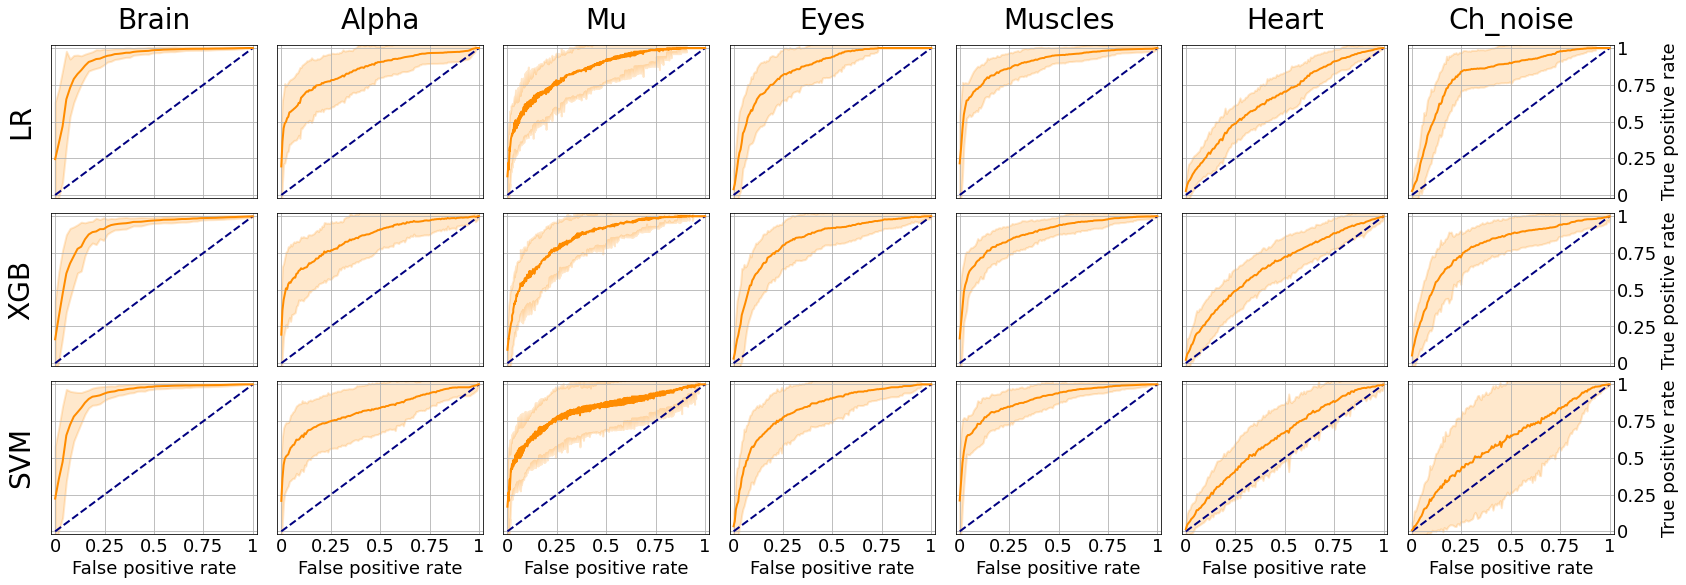

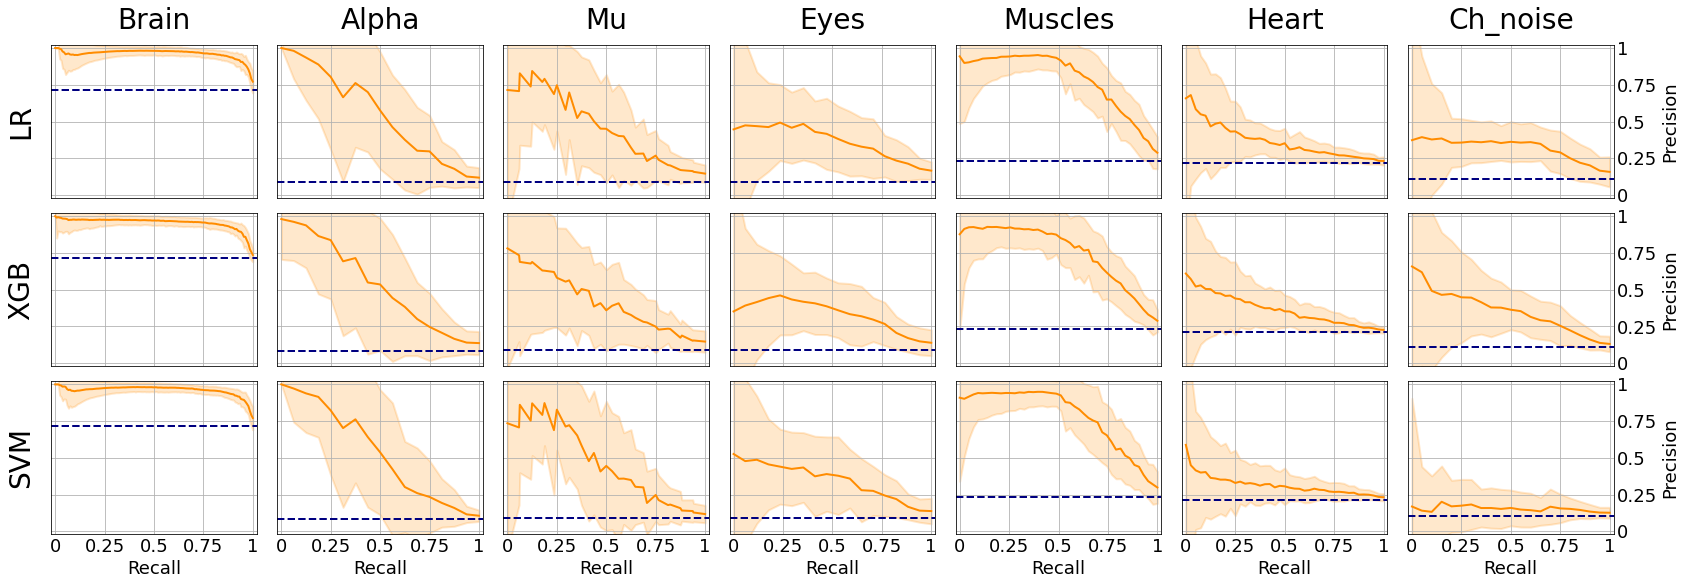

In [19]:
fig_roc, fig_pr = plot_curves_grid(features, targets, models)

In [20]:
from sklearn.metrics import auc, roc_curve, precision_recall_curve

def get_aucs(true, proba):
    roc_aucs, pr_aucs = [], []
    for true, proba in zip(y_true, y_proba):
        fpr, tpr, _ = roc_curve(true, proba, drop_intermediate=False)
        prec, rec, _ = precision_recall_curve(true, proba)
        roc_aucs.append(auc(fpr, tpr))
        pr_aucs.append(auc(rec, prec))
    return roc_aucs, pr_aucs

In [26]:
from itertools import product
from sklearn.metrics import f1_score

roc_aucs = pd.DataFrame(index=models, columns=targets.columns, dtype=float)
pr_aucs = pd.DataFrame(index=models, columns=targets.columns, dtype=float)
f1_scores = pd.DataFrame(index=models, columns=targets.columns, dtype=float)

for (model_name, model), flag in product(models.items(), targets):
        y_true, y_pred, y_proba = repeated_train_test(features, targets[flag], model, n_repeats)
        roc_auc_values, pr_auc_values = get_aucs(y_true, y_proba)
        f1_score_values = [f1_score(true, pred) for true, pred in zip(y_true, y_pred)]
        roc_aucs.loc[model_name, flag] = np.mean(roc_auc_values)
        pr_aucs.loc[model_name, flag] = np.mean(pr_auc_values)
        f1_scores.loc[model_name, flag] = np.mean(f1_score_values)


In [22]:
roc_aucs

,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_muscles,flag_heart,flag_ch_noise
LR,0.934683,0.854699,0.851263,0.862464,0.903399,0.665336,0.827657
XGB,0.916761,0.855184,0.852448,0.840877,0.886725,0.666409,0.800386
SVM,0.933056,0.826390,0.825502,0.835312,0.898419,0.633522,0.615464


In [23]:
pr_aucs

,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_muscles,flag_heart,flag_ch_noise
LR,0.962664,0.613282,0.501724,0.393058,0.801680,0.378167,0.340336
XGB,0.956960,0.601077,0.459541,0.357167,0.767177,0.377042,0.382652
SVM,0.962575,0.604888,0.522958,0.378088,0.797921,0.326309,0.173589


In [27]:
pr_aucs

,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_muscles,flag_heart,flag_ch_noise
LR,0.962664,0.613282,0.501724,0.393058,0.801680,0.378167,0.340336
XGB,0.956960,0.601077,0.459541,0.357167,0.767177,0.377042,0.382652
SVM,0.962575,0.604888,0.522958,0.378088,0.797921,0.326309,0.173589


In [24]:
f1_scores

,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_muscles,flag_heart,flag_ch_noise
LR,0.927095,0.541914,0.420501,0.264889,0.722164,0.122452,0.132333
XGB,0.916429,0.561691,0.413757,0.276461,0.705613,0.297922,0.294490
SVM,0.925954,0.507213,0.343979,0.157652,0.730832,0.000000,0.000000


For each flag we choose the model based on ROC-AUC if the classes are balanced and on F1 scores otherwise.

Save pretrained models

In [34]:
import joblib

scaler = StandardScaler()
X_train = scaler.fit_transform(features)
joblib.dump(scaler, 'scaler.joblib')

for flag in targets.columns:
    model = LogisticRegression(solver='liblinear', penalty='l2', C=1.0)
    model.fit(X_train, targets[flag])
    joblib.dump(model, 'lr_' + flag + '.joblib')    